In [3]:
import networkx as nx
import numpy as np
import pandas as pd
from genealogy_aligner import Pedigree
from genealogy_aligner.Traversal import Traversal
from genealogy_aligner.Genealogical import Genealogical
import msprime as msp
import matplotlib.pyplot as plt
from genealogy_aligner.ConstraintSatisfaction import backtrack, arc_consistency
from IPython.display import SVG, display
import constraint

In [4]:
np.random.seed(724)

families = 2
generations = 2
avg_children = 2.2
ped = Pedigree.simulate_from_founders_with_sex(families, generations, avg_children)

ped_graph = ped.get_haplotype_graph()

tree = ped_graph.sample_path(haploid_probands=True).to_coalescent_tree()

Text(0.5, 1.0, 'Coalescent tree (diploid)')

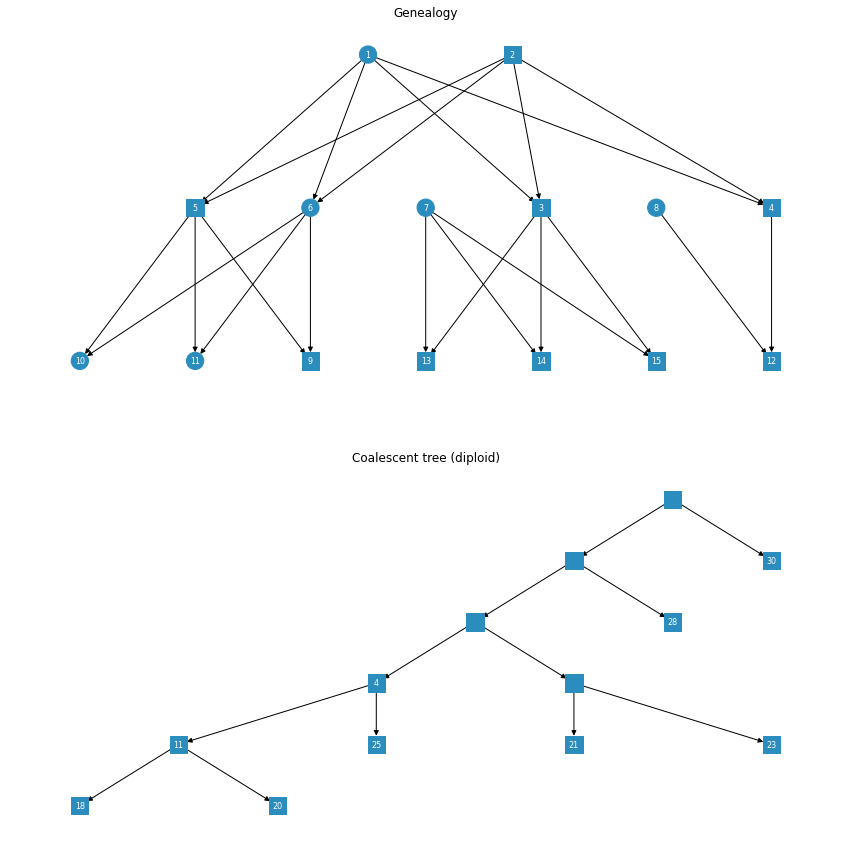

In [81]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 15))

ped.draw(ax=ax[0])
ax[0].set_title('Genealogy')
tree.draw(ax=ax[1], label_dict=tree.ts_node_to_ped_node)
ax[1].set_title('Coalescent tree (diploid)')

In [6]:
edge_labels = {}
c = 1
for u,v in tree.edges:
    edge_labels[(u,v)] = str(c)
    c = c+1

In [7]:
edge_labels

{(11, 18): '1',
 (11, 20): '2',
 (4, 11): '3',
 (4, 25): '4',
 (-1, 23): '5',
 (-1, 21): '6',
 (-2, 4): '7',
 (-2, -1): '8',
 (-3, 28): '9',
 (-3, -2): '10',
 (-4, -3): '11',
 (-4, 30): '12'}

In [8]:
pedigree = copy.deepcopy(ped)

In [9]:
coal_edge = {}
for node in tree.nodes:
    if (node not in tree.probands()):
        for succ in tree.successors(node):
            for pred in tree.predecessors(node):
                coal_edge[edge_labels[(node,succ)]]=edge_labels[(pred,node)]
coal_edge

{'1': '3',
 '2': '3',
 '3': '7',
 '4': '7',
 '5': '8',
 '6': '8',
 '7': '10',
 '8': '10',
 '9': '11',
 '10': '11'}

In [10]:
variables = pedigree.nodes

In [20]:
domains = {}
domain = list(edge_labels.values())
domain.append('x')
domain
for v in variables:
    domains[v]=domain

In [176]:
possible_triplets = []
impossible_triplets = []

for e in edge_labels.values():
    possible_triplets.append((e,e,'x'))
    possible_triplets.append((e,'x',e))
    possible_triplets.append(('x','x',e))
    possible_triplets.append(('x',e,'x'))
    if e in coal_edge.keys():
        possible_triplets.append((e,coal_edge[e],'x'))
        possible_triplets.append((e,'x',coal_edge[e]))
possible_triplets                

In [80]:
invalid = []
for edge in coal_edge.keys():
    for i in domain:
        if coal_edge[edge]!= i and edge!=i:
            invalid.append((edge,i))
invalid

[('1', '2'),
 ('1', '4'),
 ('1', '5'),
 ('1', '6'),
 ('1', '7'),
 ('1', '8'),
 ('1', '9'),
 ('1', '10'),
 ('1', '11'),
 ('1', '12'),
 ('1', 'x'),
 ('2', '1'),
 ('2', '4'),
 ('2', '5'),
 ('2', '6'),
 ('2', '7'),
 ('2', '8'),
 ('2', '9'),
 ('2', '10'),
 ('2', '11'),
 ('2', '12'),
 ('2', 'x'),
 ('3', '1'),
 ('3', '2'),
 ('3', '4'),
 ('3', '5'),
 ('3', '6'),
 ('3', '8'),
 ('3', '9'),
 ('3', '10'),
 ('3', '11'),
 ('3', '12'),
 ('3', 'x'),
 ('4', '1'),
 ('4', '2'),
 ('4', '3'),
 ('4', '5'),
 ('4', '6'),
 ('4', '8'),
 ('4', '9'),
 ('4', '10'),
 ('4', '11'),
 ('4', '12'),
 ('4', 'x'),
 ('5', '1'),
 ('5', '2'),
 ('5', '3'),
 ('5', '4'),
 ('5', '6'),
 ('5', '7'),
 ('5', '9'),
 ('5', '10'),
 ('5', '11'),
 ('5', '12'),
 ('5', 'x'),
 ('6', '1'),
 ('6', '2'),
 ('6', '3'),
 ('6', '4'),
 ('6', '5'),
 ('6', '7'),
 ('6', '9'),
 ('6', '10'),
 ('6', '11'),
 ('6', '12'),
 ('6', 'x'),
 ('7', '1'),
 ('7', '2'),
 ('7', '3'),
 ('7', '4'),
 ('7', '5'),
 ('7', '6'),
 ('7', '8'),
 ('7', '9'),
 ('7', '11'),
 ('7',

In [74]:
same = []
incr = []
decr = []
for e in domain:
    for f in domain:
        if (e == f):
            same.append((e,f))
        if (e > f):
            incr.append((e,f))
        else:
            decr.append((e,f))

In [76]:
constraints = {}
for n in pedigree.nodes:
    par = pedigree.get_parents(n)
    if par[0]!= 0 and par[1]!= 0 :
        constraints.setdefault((n,par[0]), [])
        constraints.setdefault((n,par[1]), [])
        constraints.setdefault((par[0],n), [])
        constraints.setdefault((par[1],n), [])
        for i in invalid:
            constraints[(n,par[0])].append((i[0],i[1]))
            constraints[(n,par[1])].append((i[0],i[1]))
            constraints[(par[0],n)].append((i[0],i[1]))
            constraints[(par[1],n)].append((i[0],i[1]))
        for j in incr:
            constraints[(n,par[0])].append((j[0],j[1]))
            constraints[(n,par[1])].append((j[0],j[1]))
        for k in decr:
            constraints[(par[0],n)].append((k[0],k[1]))
            constraints[(par[1],n)].append((k[0],k[1]))
constraints

{(3, 2): [('1', '2'),
  ('1', '4'),
  ('1', '5'),
  ('1', '6'),
  ('1', '7'),
  ('1', '8'),
  ('1', '9'),
  ('1', '10'),
  ('1', '11'),
  ('1', '12'),
  ('1', 'x'),
  ('2', '1'),
  ('2', '4'),
  ('2', '5'),
  ('2', '6'),
  ('2', '7'),
  ('2', '8'),
  ('2', '9'),
  ('2', '10'),
  ('2', '11'),
  ('2', '12'),
  ('2', 'x'),
  ('3', '1'),
  ('3', '2'),
  ('3', '4'),
  ('3', '5'),
  ('3', '6'),
  ('3', '8'),
  ('3', '9'),
  ('3', '10'),
  ('3', '11'),
  ('3', '12'),
  ('3', 'x'),
  ('4', '1'),
  ('4', '2'),
  ('4', '3'),
  ('4', '5'),
  ('4', '6'),
  ('4', '8'),
  ('4', '9'),
  ('4', '10'),
  ('4', '11'),
  ('4', '12'),
  ('4', 'x'),
  ('5', '1'),
  ('5', '2'),
  ('5', '3'),
  ('5', '4'),
  ('5', '6'),
  ('5', '7'),
  ('5', '9'),
  ('5', '10'),
  ('5', '11'),
  ('5', '12'),
  ('5', 'x'),
  ('6', '1'),
  ('6', '2'),
  ('6', '3'),
  ('6', '4'),
  ('6', '5'),
  ('6', '7'),
  ('6', '9'),
  ('6', '10'),
  ('6', '11'),
  ('6', '12'),
  ('6', 'x'),
  ('7', '1'),
  ('7', '2'),
  ('7', '3'),
  ('7', 

In [77]:
for n in pedigree.nodes:
    for m in pedigree.nodes:
        if n<m and pedigree.get_parents(n)==pedigree.get_parents(m):
            if pedigree.get_parents(n)!= 0 and pedigree.get_parents(m)!= 0:
                constraints[(n,m)]=same

In [78]:
ac_result = arc_consistency(variables, domains, constrains)
ac_result

True

In [79]:
backtrack({}, variables, domains, constrains, "MAC")

{1: '1', 2: '2', 3: '1', 4: '2', 5: '3', 6: '4', 7: '3', 8: '4', 9: '1', 10: '2', 11: '3', 12: '1', 13: '1', 14: '2', 15: '3'}
{1: '1', 2: '2', 3: '1', 4: '2', 5: '3', 6: '4', 7: '3', 8: '4', 9: '1', 10: '2', 11: '3', 12: '1', 13: '1', 14: '2', 15: '4'}
{1: '1', 2: '2', 3: '1', 4: '2', 5: '3', 6: '4', 7: '3', 8: '4', 9: '1', 10: '2', 11: '3', 12: '1', 13: '1', 14: '2', 15: '5'}
{1: '1', 2: '2', 3: '1', 4: '2', 5: '3', 6: '4', 7: '3', 8: '4', 9: '1', 10: '2', 11: '3', 12: '1', 13: '1', 14: '2', 15: '6'}
{1: '1', 2: '2', 3: '1', 4: '2', 5: '3', 6: '4', 7: '3', 8: '4', 9: '1', 10: '2', 11: '3', 12: '1', 13: '1', 14: '2', 15: '7'}
{1: '1', 2: '2', 3: '1', 4: '2', 5: '3', 6: '4', 7: '3', 8: '4', 9: '1', 10: '2', 11: '3', 12: '1', 13: '1', 14: '2', 15: '8'}
{1: '1', 2: '2', 3: '1', 4: '2', 5: '3', 6: '4', 7: '3', 8: '4', 9: '1', 10: '2', 11: '3', 12: '1', 13: '1', 14: '2', 15: '9'}
{1: '1', 2: '2', 3: '1', 4: '2', 5: '3', 6: '4', 7: '3', 8: '4', 9: '1', 10: '2', 11: '3', 12: '1', 13: '1', 14